# <div align="center"> Utilizing SVM and CNN Models for Breast Cancer Detection with Mammography and Ultrasound Imaging </div>

Group 5:
* Almira Zahra Aurelia – 00000080298
* Darren Irawan Djong – 00000081041
* Kayla Abigail Gunawan – 00000081824
* Sabrina Fajrul Ula Usman – 00000083124

# Convolutional Neural Networks (CNN)

Ultrasound Image Dataset (with Data Augmentation)

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Define data paths
data_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/image ml/Dataset_BUSI_with_GT"
benign_path = os.path.join(data_path, "benign")
malignant_path = os.path.join(data_path, "malignant")
normal_path = os.path.join(data_path, "normal")

In [3]:
# Load images and labels
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)  # Read image without specifying grayscale
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image as needed
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

In [4]:
# Load images and labels
benign_images, benign_labels = load_images(benign_path, "benign")
malignant_images, malignant_labels = load_images(malignant_path, "malignant")
normal_images, normal_labels = load_images(normal_path, "normal")

100%|██████████| 133/133 [00:00<00:00, 158.28it/s]


In [5]:
# Combine images and labels
all_images = benign_images + malignant_images + normal_images
all_labels = benign_labels + malignant_labels + normal_labels

In [6]:
# Convert to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

In [7]:
np.unique(y)

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [8]:
import pandas as pd

pd.Series(y).value_counts()

benign       437
malignant    210
normal       133
Name: count, dtype: int64

In [9]:
# Encode class labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)

In [10]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, random_state=42, test_size=0.2)

In [11]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True  # randomly flip images
)

# Fit the data augmentation generator to the training data
datagen.fit(x_train)

In [12]:
# Reshape and normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [13]:
# Menampilkan bentuk data latih dan data uji untuk memeriksa apakah dimensinya sesuai.
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (624, 100, 100, 3)
Shape of y_train: (624, 3)

Shape of x_test: (156, 100, 100, 3)
Shape of y_test: (156, 3)


# Let's display as image

Image (#4): Which is digit '[1. 0. 0.]'


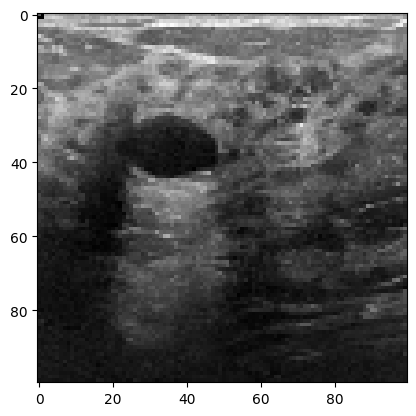

In [14]:
# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 4 # Change to choose new digit
a = x_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))

# SHOW MORE RANDOM DATA

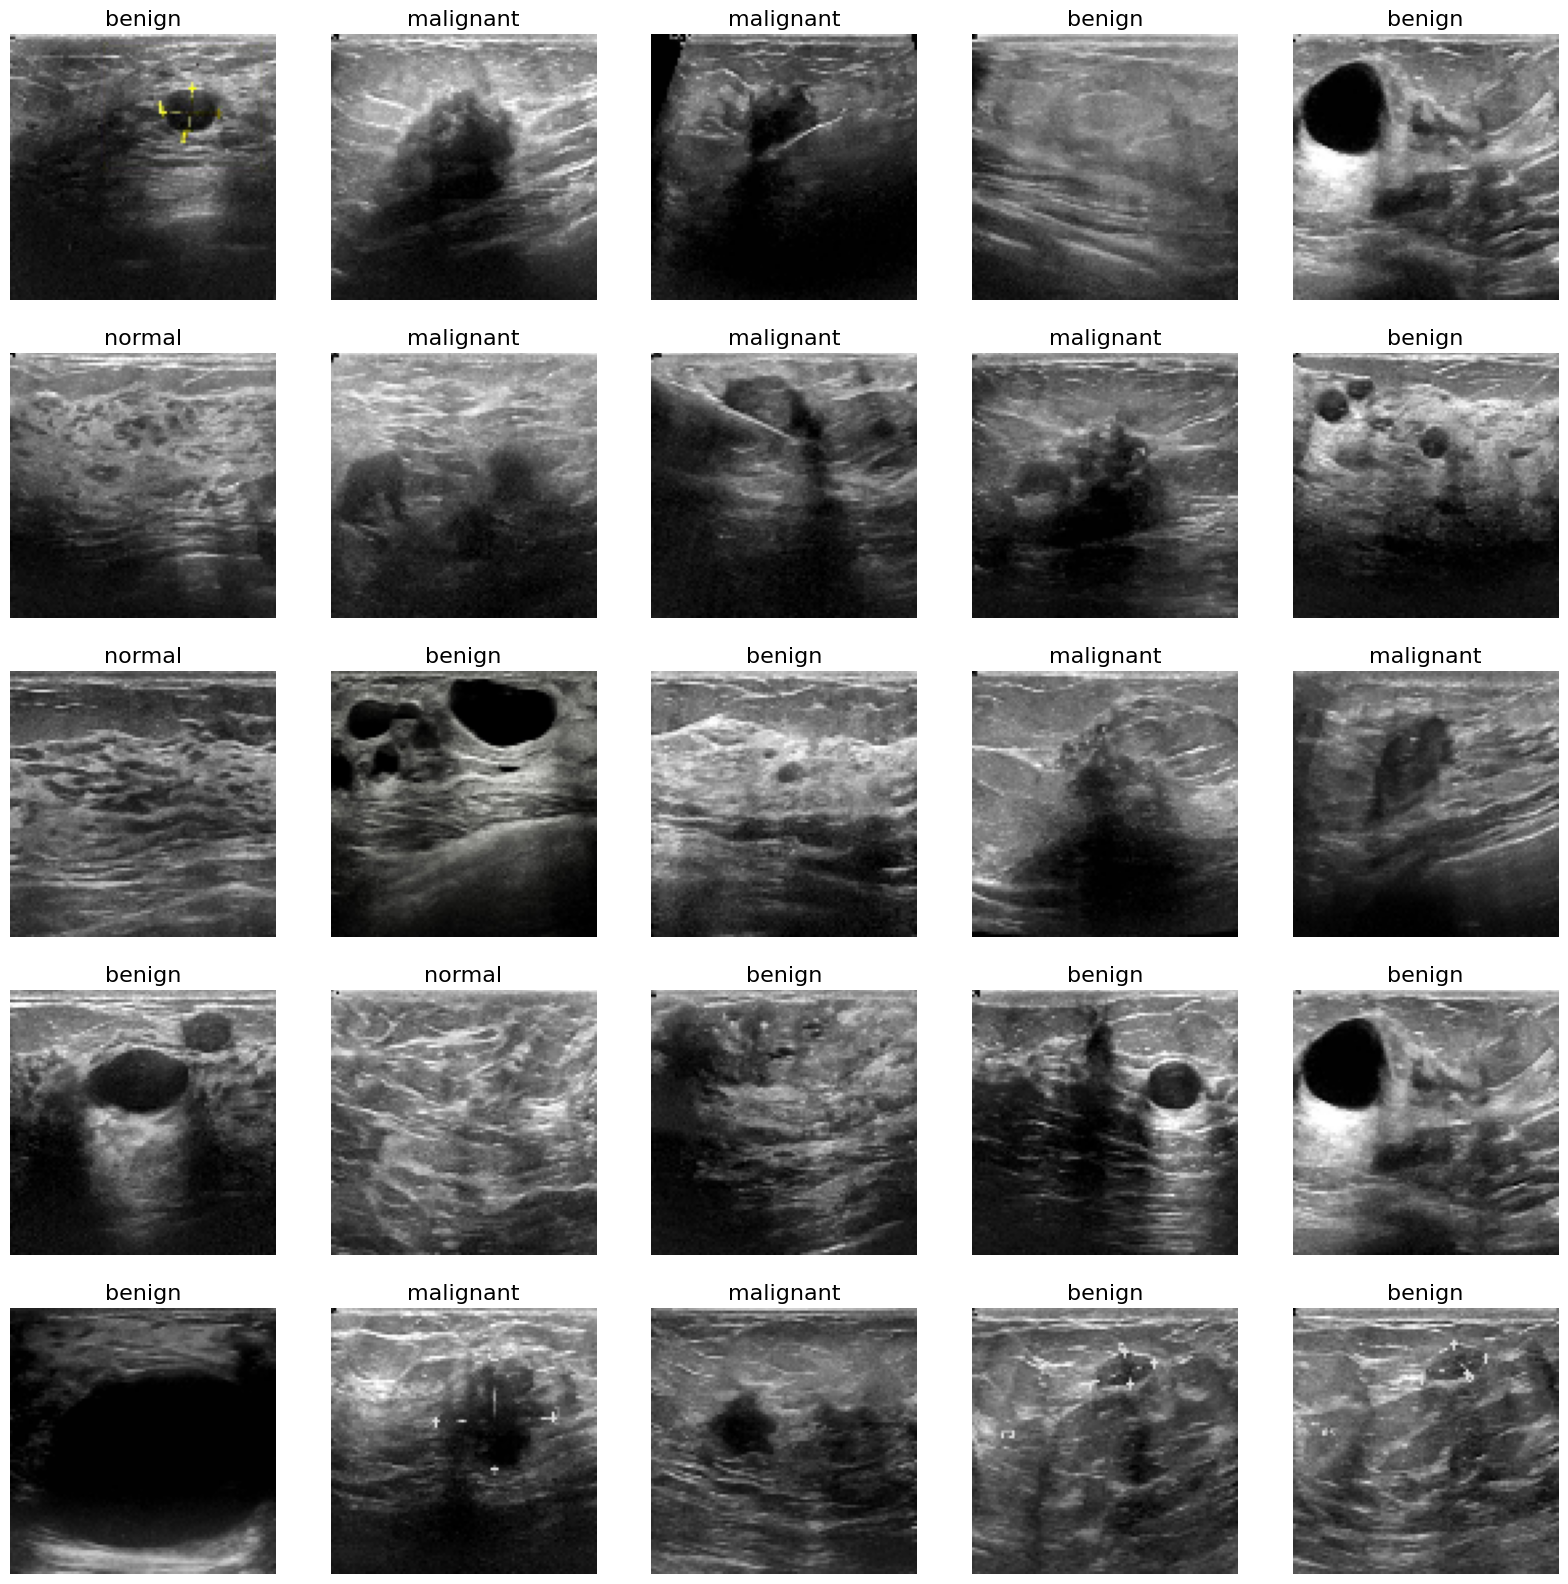

In [15]:
def show_random_image_samples(x_data, y_data, num_samples=25):
    # Randomly select indices
    indices = np.random.choice(range(x_data.shape[0]), num_samples, replace=False)
    images = x_data[indices]
    labels = y_data[indices]

    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        # Remove the reshape operation
        image = images[i]
        label_index = np.argmax(labels[i])
        label_name = label_encoder.inverse_transform([label_index])[0]
        plt.imshow(image, cmap='gray')
        plt.title(label_name, color='black', fontsize=16)
        plt.axis('off')
    plt.show()

# Show random samples
show_random_image_samples(x_train, y_train)

# CREATE THE MODEL

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False

In [17]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 12, 12, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 12, 12, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 6, 6, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 6, 6, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 6, 6, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 6, 6, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 6, 6, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 6, 6, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_10[0][0]']                 
 on)      

In [18]:
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 32)          0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                        

# TRAIN MODEL

In [20]:
import time

start_time = time.time()

history = model.fit(x_train, y_train,  # Use x_train instead of x_train_rgb
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(x_test, y_test))  # Use x_test instead of x_test_rgb

elapsed_time = time.time() - start_time
print("Elapsed time:", elapsed_time)

Epoch 1/10
20/20 - 11s - loss: 0.9627 - accuracy: 0.5689 - val_loss: 0.7743 - val_accuracy: 0.6410 - 11s/epoch - 562ms/step
Epoch 2/10
20/20 - 6s - loss: 0.8023 - accuracy: 0.6635 - val_loss: 0.7369 - val_accuracy: 0.7051 - 6s/epoch - 321ms/step
Epoch 3/10
20/20 - 6s - loss: 0.6742 - accuracy: 0.6939 - val_loss: 0.7328 - val_accuracy: 0.6731 - 6s/epoch - 310ms/step
Epoch 4/10
20/20 - 7s - loss: 0.6054 - accuracy: 0.7372 - val_loss: 0.7363 - val_accuracy: 0.6731 - 7s/epoch - 343ms/step
Epoch 5/10
20/20 - 7s - loss: 0.5675 - accuracy: 0.7276 - val_loss: 0.6810 - val_accuracy: 0.7564 - 7s/epoch - 340ms/step
Epoch 6/10
20/20 - 6s - loss: 0.4998 - accuracy: 0.7869 - val_loss: 0.6986 - val_accuracy: 0.7500 - 6s/epoch - 307ms/step
Epoch 7/10
20/20 - 7s - loss: 0.4889 - accuracy: 0.7917 - val_loss: 0.6485 - val_accuracy: 0.7756 - 7s/epoch - 337ms/step
Epoch 8/10
20/20 - 7s - loss: 0.4268 - accuracy: 0.8045 - val_loss: 0.6928 - val_accuracy: 0.7821 - 7s/epoch - 328ms/step
Epoch 9/10
20/20 - 6s 

# EVALUATION

In [21]:
# Evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6666762232780457
Test accuracy: 0.75


In [22]:
from sklearn import metrics

small_x = x_test[1:100]
small_y = y_test[1:100]
small_y2 = np.argmax(small_y,axis=1)
pred = model.predict(small_x)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(small_y2, pred)
print('Accuracy: {}'.format(score))

4/4 [==============================] - 2s 194ms/step
Accuracy: 0.7676767676767676


In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

# Predict probabilities for each class
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Generate classification report
class_rep = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

5/5 [==============================] - 1s 231ms/step


Classification Report:
               precision    recall  f1-score   support

      benign       0.76      0.81      0.78        84
   malignant       0.72      0.67      0.70        43
      normal       0.77      0.69      0.73        29

    accuracy                           0.75       156
   macro avg       0.75      0.72      0.74       156
weighted avg       0.75      0.75      0.75       156



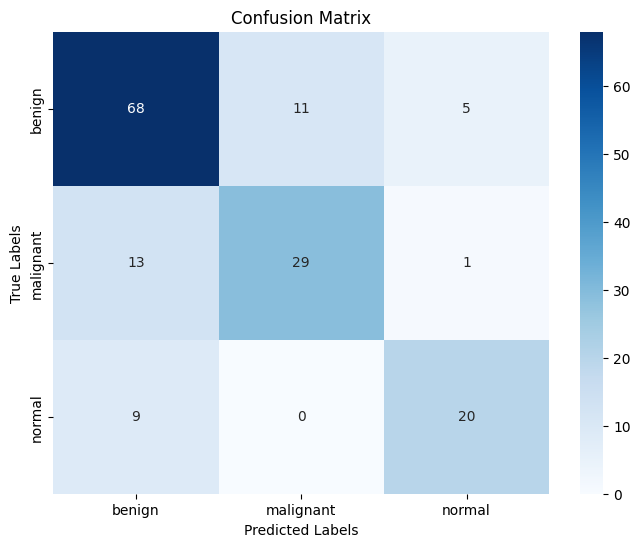

In [24]:
# Display classification report
print("Classification Report:\n", class_rep)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CROSS VALIDATION 
## Using StratifiedKFold Cross Validation

In [25]:
from sklearn.model_selection import StratifiedKFold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvscores = []
from tensorflow.keras.callbacks import EarlyStopping

for train_index, val_index in skf.split(x_train, np.argmax(y_train, axis=1)):
    x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    model.fit(x_fold_train, y_fold_train,
              batch_size=128,
              epochs=12,
              verbose=1,
              validation_data=(x_fold_val, y_fold_val),
              callbacks=[early_stopping])

    scores = model.evaluate(x_fold_val, y_fold_val, verbose=0)
    print(f"Fold accuracy: {scores[1]*100}%")
    cvscores.append(scores[1] * 100)

print(f"Mean accuracy: {np.mean(cvscores)}%")
print(f"Standard deviation: {np.std(cvscores)}%")

Epoch 1/12
4/4 [==============================] - 5s 1s/step - loss: 0.3696 - accuracy: 0.8497 - val_loss: 0.2087 - val_accuracy: 0.9360
Epoch 2/12
4/4 [==============================] - 5s 1s/step - loss: 0.3061 - accuracy: 0.8697 - val_loss: 0.2049 - val_accuracy: 0.9360
Epoch 3/12
4/4 [==============================] - 4s 1s/step - loss: 0.3496 - accuracy: 0.8337 - val_loss: 0.2061 - val_accuracy: 0.9440
Epoch 4/12
4/4 [==============================] - 4s 1s/step - loss: 0.3114 - accuracy: 0.8737 - val_loss: 0.2127 - val_accuracy: 0.9440
Epoch 5/12
4/4 [==============================] - 5s 1s/step - loss: 0.3202 - accuracy: 0.8537 - val_loss: 0.2113 - val_accuracy: 0.9440
Fold accuracy: 94.40000057220459%
Epoch 1/12
4/4 [==============================] - 5s 1s/step - loss: 0.3159 - accuracy: 0.8818 - val_loss: 0.1715 - val_accuracy: 0.9840
Epoch 2/12
4/4 [==============================] - 5s 1s/step - loss: 0.2926 - accuracy: 0.8798 - val_loss: 0.1633 - val_accuracy: 0.9680
Epoch 3

# NEW QUERY

In [26]:
# Save the model
model.save("UltraSound_CNN.h5")

In [27]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("UltraSound_CNN.h5")
model

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the model
model = load_model("UltraSound_CNN.h5")

# Define a function to preprocess new images
def preprocess_image(img_path):
    img = cv2.imread(img_path)  # Read image
    if img is None:
        print(f"Warning: Unable to read image {img_path}.")
        return None
    img = cv2.resize(img, (100, 100))  # Resize image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img.astype('float32') / 255  # Normalize the image
    return img

# Define the path to the new images
new_data_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/DATA FOR NEW QUERY"
benign_path = os.path.join(new_data_path, "Benign")
malignant_path = os.path.join(new_data_path, "Malignant")

# Load and preprocess new images
def load_new_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

benign_images, benign_labels = load_new_images(benign_path, 'benign')
malignant_images, malignant_labels = load_new_images(malignant_path, 'malignant')

# Combine the images and labels
new_images = benign_images + malignant_images
new_labels = benign_labels + malignant_labels

# Convert list to numpy array
new_images = np.array(new_images)

# Predict the class of new images
predictions = model.predict(new_images)
predicted_classes = np.argmax(predictions, axis=1)

# Decode the predicted labels
label_decoder = {0: 'benign', 1: 'malignant', 2: 'normal'}
decoded_predictions = [label_decoder[pred] for pred in predicted_classes]

# True labels for the new images
true_labels = new_labels

# Encode true labels into integers
label_encoder = {v: k for k, v in label_decoder.items()}
true_labels_encoded = [label_encoder[label] for label in true_labels]

8/8 [==============================] - 4s 294ms/step


In [2]:
# Calculate accuracy
accuracy = accuracy_score(true_labels_encoded, predicted_classes)
print(f'Accuracy on new data: {accuracy * 100:.2f}%')

# Display the results
for filename, pred, true_label in zip(os.listdir(benign_path) + os.listdir(malignant_path), decoded_predictions, true_labels):
    print(f"Image: {filename} - Predicted: {pred} - True Label: {true_label}")

Accuracy on new data: 52.59%
Image: 1 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 10 Benign Image.bmp - Predicted: malignant - True Label: benign
Image: 100 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 101 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 102 Benign Image.bmp - Predicted: malignant - True Label: benign
Image: 103 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 104 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 105 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 106 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 107 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 108 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 109 Benign Image.bmp - Predicted: benign - True Label: benign
Image: 11 Benign Image.bmp - Predicted: malignant - True Label: benign
Image: 12 Benign Image.bmp - Predicted: benign - True Label: benign
I

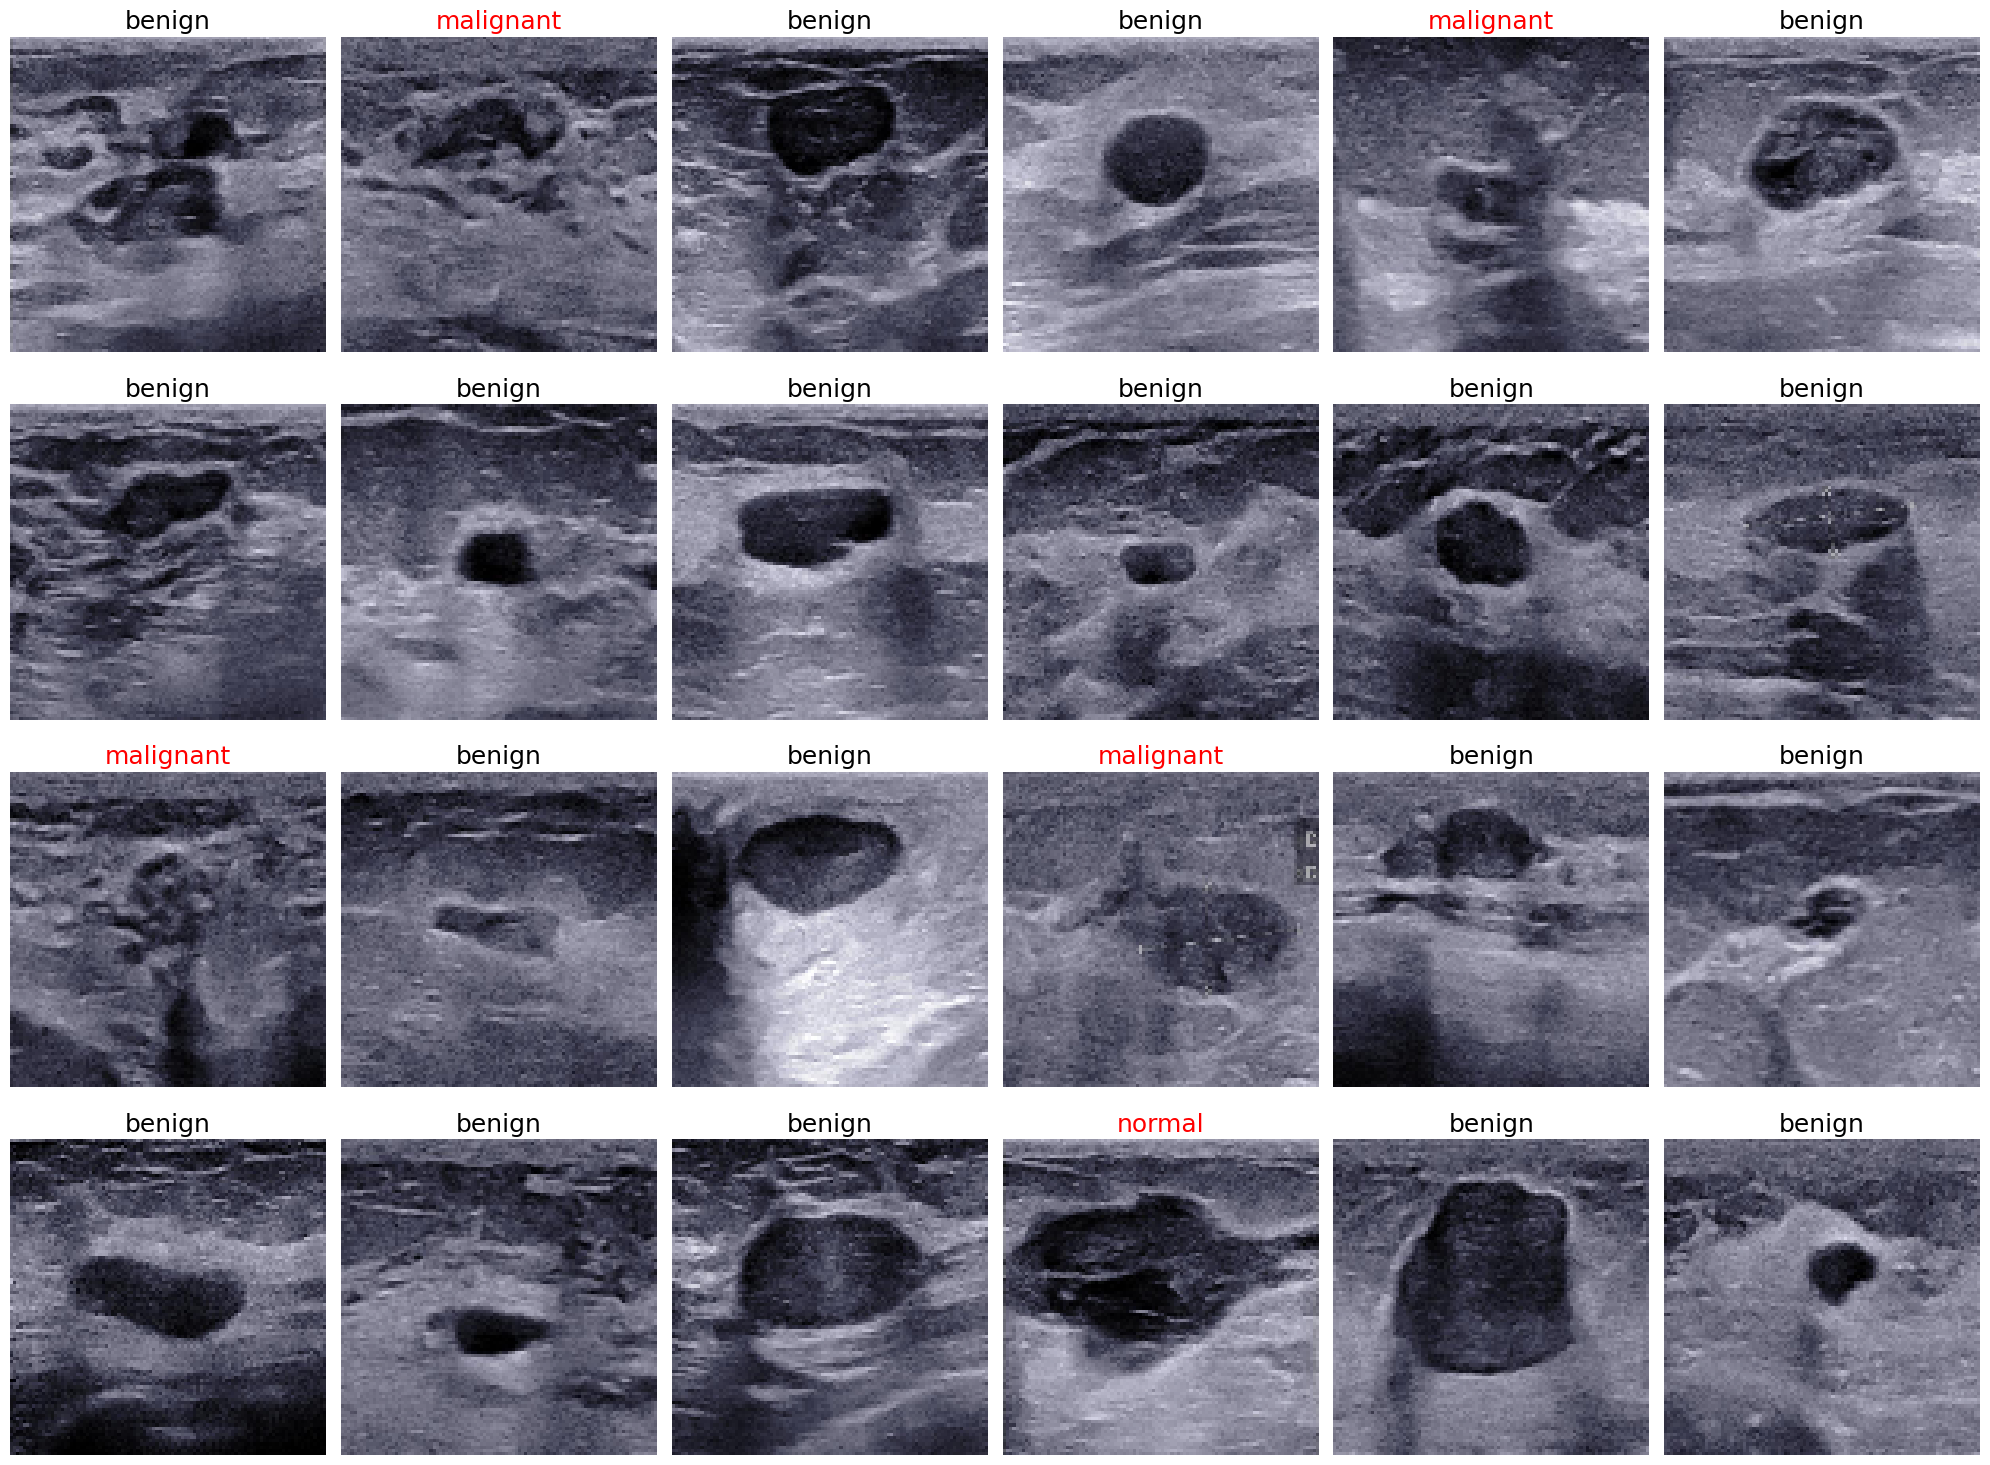

In [3]:
# Optionally, display the images with their predicted labels in a 4x6 grid
def display_predictions(images, predictions, true_labels, num_samples=24):
    plt.figure(figsize=(20, 15))
    for i in range(min(num_samples, len(images))):
        plt.subplot(4, 6, i + 1)
        image = images[i]
        pred_label = predictions[i]
        true_label = true_labels[i]
        color = 'black' if pred_label == true_label else 'red'
        plt.imshow(image)
        plt.title(pred_label, color=color, fontsize=18)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the predictions
display_predictions(new_images, decoded_predictions, true_labels)

---